In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import torch
from pathlib import Path
from hython.utils import write_to_zarr, build_mask_dataarray
import matplotlib.pyplot as plt
from pathlib import Path
from hython.datasets.datasets import get_dataset, CubeletsDataset
from numcodecs import Blosc

from torch.utils.data import Dataset, DataLoader

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
from hython.trainer import HythonTrainer
from hython.trainer import train_val
from hython.sampler import SamplerBuilder
from hython.metrics import MSEMetric
from hython.losses import RMSELoss
from hython.utils import read_from_zarr, set_seed
from hython.models.cudnnLSTM import CuDNNLSTM
from hython.trainer import RNNTrainer, RNNTrainParams
from hython.normalizer import Normalizer


from hython.sampler import compute_grid_indices
import itertools


import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#from torchvision.datasets import MovingMNIST

In [6]:
dir_surr_input = Path("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs")


static = xr.open_dataset(dir_surr_input / "staticmaps.nc")#.chunk("auto")
dynamic = xr.open_dataset(dir_surr_input/ "forcings.nc").chunk("auto") # C T W H => N T C H W
target = xr.open_dataset(dir_surr_input / "run_default/output.nc").sel(layer=1).isel(lat=slice(None, None, -1))#.chunk("auto") # C T W H => N T C H W


surr_model_output = "convlstm.pt"
experiment = "exp1" # experiment name

dir_surr_output = "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model"

SEED = 1696

dynamic_names = ["precip", "pet", "temp"] 
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] 
target_names = [ "vwc", "actevap"] 

mask_from_static = ["thetaS","wflow_lakeareas"]
rename_mask = ["mask_missing", "mask_lake"]


dataset = "XBatchDataset"


# DL model hyper parameters
HIDDEN_SIZE = 24
DYNAMIC_INPUT_SIZE = len(dynamic_names)
STATIC_INPUT_SIZE = len(static_names)
KERNEL_SIZE = (3, 3)
NUM_LSTM_LAYER = 2
OUTPUT_SIZE = len(target_names)


TARGET_WEIGHTS = {t:1/len(target_names) for t in target_names}


soil_layers = [1]
# train/test parameters
train_temporal_range = slice("2016-01-01","2018-12-31")
test_temporal_range = slice("2019-01-01", "2020-12-31")

EPOCHS = 50
BATCH = 64
TEMPORAL_SUBSAMPLING = True
TEMPORAL_SUBSET = [150, 150] 
SEQ_LENGTH = 360


assert sum(v for v in TARGET_WEIGHTS.values()) == 1, "check target weights"
TARGET_INITIALS = "".join([i[0].capitalize() for i in target_names])


In [6]:
wd = Path("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs")

In [7]:
try:
    dynamic = dynamic.rename({"latitude":"lat", "longitude":"lon"})
    static = static.rename({"latitude":"lat", "longitude":"lon"})
except:
    pass

In [8]:
# masking 

# filter soil layers 
if len(soil_layers) > 0:
    if len(soil_layers) == 1:
        static = static.sel(layer=soil_layers).squeeze("layer")
        #target = target.sel(layer=soil_layers).squeeze("layer")

    else:
        raise NotImplementedError("Preprocessing multiple soil layers not yet implemented")
    
# masking, TODO: Improve the logic.
masks = []

for i, mask in enumerate(mask_from_static):
    if i == 0:
        masks.append(np.isnan(static[mask]).rename(rename_mask[i]))
    else:
        masks.append((static[mask] > 0).astype(np.bool_).rename(rename_mask[i]))

masks = build_mask_dataarray(masks, names = rename_mask)

In [9]:
wflow_dem = static.wflow_dem

In [10]:
# filter 
dynamic = dynamic[dynamic_names]
target = target[target_names]
static = static.drop_dims("time")[ static_names ] 

In [11]:
# # expand static to dynamic 
# time_da = xr.DataArray(dynamic.time.values, [('time', dynamic.time.values)])
# static = static.expand_dims({"time":time_da})

In [12]:
# dynamic = dynamic.to_array() # C T H W
# static = static.to_array() # C T H W
# target = target.to_array() # C T H W

In [13]:
dynamic_train = dynamic.sel(time=train_temporal_range)
static = static#.sel(time=train_temporal_range)
target_train = target.sel(time=train_temporal_range)

dynamic_test = dynamic.sel(time=test_temporal_range)
target_test = target.sel(time=test_temporal_range)

In [14]:
masks = masks.sel(mask_layer=rename_mask).any(dim="mask_layer")

In [15]:
# temp = dynamic_train.to_stacked_array( new_dim="feat", sample_dims = ["time", "lat", "lon"]) # time, lat, lon , feat
# temp = temp.transpose("time", "feat", "lat" , "lon") # T C H W
# temp = temp.astype("float32")

In [16]:
# # normalize

# normalizer_dynamic = Normalizer(method="standardize", type="spacetime", shape="2D")

# normalizer_static = Normalizer(method="standardize", type="space", shape="2D")

# normalizer_target = Normalizer(method="standardize", type="spacetime", shape="2D")

# normalizer_dynamic.compute_stats(dynamic_train.to_array())
# normalizer_static.compute_stats(static_train.to_array())
# normalizer_target.compute_stats(target_train.to_array())

# dynamic = normalizer_dynamic.normalize(dynamic_train)
# static = normalizer_static.normalize(static_train)
# target = normalizer_target.normalize(target_train)

# dynamic_test = normalizer_dynamic.normalize(dynamic_test)
# static_test = normalizer_static.normalize(static_test)
# target_test = normalizer_target.normalize(target_test)

In [17]:
# # masking 
# dynamic_train = dynamic_train.where(~masks, 0)

# static_train = static_train.where(~masks, 0)

# target_train = target_train.where(~masks, 0)


# dynamic_test = dynamic_test.where(~masks, 0)

# static_test = static_test.where(~masks, 0)

# target_test = target_test.where(~masks, 0)

In [18]:
# compressor = Blosc(cname='zl4', clevel=9, shuffle=Blosc.BITSHUFFLE)

# ss = params.drop_dims("time")[[ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"]].expand_dims({"time": ds.time}).chunk({"time":500, "latitude":50, "longitude":50})

# ss.to_zarr(wd / "test.zarr",storage_options={"compressor":compressor})

# ss = xr.open_dataset( wd / "test.zarr", engine = "zarr")

# time, lat, lon = 365, 16, 16 

## Test xbatcher

Check whether I can get and index of the chunks so that I can do:

$$ \mathbf{f}: \mathbb{R}^1 \rightarrow \mathbb{R}^2$$

f(0) => (0,0) </br>
f(1) => (0,1) </br>
f(2) => (1,0) </br>
f(3) => (1,1) </br>

In [220]:
# xgen = xbatcher.BatchGenerator(
#     dynamic_train,
#     input_dims={"lat":80, "lon":80, "time":360}, # dimension size of the sample cube
#     preload_batch=True,
#     #batch_dims={"time":60, "lat":80, "lon":80},
#     #concat_input_dims= True,
#     #input_overlap={"time":10, "lat":10, "lon":10} # overlaps between dimensions of each cube
# )

# len(xgen)

# sample = xgen[11]

# ds = xr.merge(xgen)

# ds.isel(time=199).precip.plot()

# # this should work for the convLSTM 
# sample_convlstm = sample.to_stacked_array(new_dim="feat", sample_dims=("lat","lon", "time"))

# sample_convlstm.shape

# # how to handle null cubes
# sample_convlstm.isnull().all().item(0)

# #sample_convlstm.sel(feat="precip").isel(time=10).plot()

# # this should work for the 1D lstm
# sample_lstm = sample_convlstm.stack(gridcell=["lat","lon"])

# #ds.sel(variable="precip").to_dataset(name="ds").to_stacked_array(new_dim="batch", sample_dims=("lon","lat"))

## Example xbatcher from https://github.com/earth-mover/dataloader-demo/blob/main/main.py

In [221]:
# def print_json(obj):
#     print(json.dumps(obj))
# from torch.utils.data import Dataset as TorchDataset
# import multiprocessing
# class XBatcherPyTorchDataset(TorchDataset):
#     def __init__(self, batch_generator: xbatcher.BatchGenerator):
#         self.bgen = batch_generator

#     def __len__(self):
#         return len(self.bgen)

#     def __getitem__(self, idx):
#         t0 = time.time()
#         print_json(
#             {
#                 "event": "get-batch start",
#                 "time": t0,
#                 "idx": idx,
#                 "pid": multiprocessing.current_process().pid,
#             }
#         )
#         # load before stacking
#         batch = self.bgen[idx].load()

#         print(batch)

#         # Use to_stacked_array to stack without broadcasting,
#         stacked = batch.to_stacked_array(
#             new_dim="batch", sample_dims=("time", "longitude", "latitude")
#         ).transpose("time", "batch", ...)
#         print(stacked)
#         x = torch.tensor(stacked.data)
#         t1 = time.time()
#         print_json(
#             {
#                 "event": "get-batch end",
#                 "time": t1,
#                 "idx": idx,
#                 "pid": multiprocessing.current_process().pid,
#                 "duration": t1 - t0,
#             }
#         )
#         return x

# import time, json
# def setup(source="gcs", patch_size: int = 48, input_steps: int = 3):
#     if source == "gcs":
#         ds = xr.open_dataset(
#             "gs://weatherbench2/datasets/era5/1959-2022-6h-128x64_equiangular_with_poles_conservative.zarr",
#             engine="zarr",
#             chunks={},
#         )
#     elif source == "arraylake":
#         config.set({"s3.endpoint_url": "https://storage.googleapis.com", "s3.anon": True})
#         ds = (
#             Client()
#             .get_repo("earthmover-public/weatherbench2")
#             .to_xarray(
#                 group="datasets/era5/1959-2022-6h-128x64_equiangular_with_poles_conservative",
#                 chunks={},
#             )
#         )
#     else:
#         raise ValueError(f"Unknown source {source}")

#     DEFAULT_VARS = [
#         "10m_wind_speed",
#         "2m_temperature",
#         "specific_humidity",
#     ]

#     ds = ds[DEFAULT_VARS]
#     patch = dict(
#         latitude=patch_size,
#         longitude=patch_size,
#         time=input_steps,
#     )
#     overlap = dict(latitude=32, longitude=32, time=input_steps // 3 * 2)

#     bgen = xbatcher.BatchGenerator(
#         ds,
#         input_dims=patch,
#         input_overlap=overlap,
#         preload_batch=False,
#     )

#     dataset = XBatcherPyTorchDataset(bgen)

#     return dataset

# xgen = setup()

# len(xgen)

# ds = xgen[1]

# res = res[1]
# res.shape, res.dims, res.coords, len(xgen)

# # for i, b in enumerate(xgen):
# #     print(i)
# #     print(b.shape)
# #     plt.figure()
# #     try:
# #         b.isel(variable_input=1, sample=0).plot()
# #         b.isel(variable_input=1, lat_input=100, lon_input=100).plot(x="time")
# #     except Exception as e:
# #         print(e)
# #         b.isel(variable=1, time=1).plot()
# #         b.isel(variable=1, lat=10, lon=10).plot()
# #     if i > 20:
# #         break

## Test custom "xbatcher"

The current implementation of xbatcher looks cool but it lacks:
- way to index tiles and sequence, it only indexes cubes, therefore how I can subsample only in one of the two dimensions?
- as I don't know the ordering of the cube samples, how can I subsample?
- how to handle NULL cubes
- It drops the "edges" of the dimension (i.e. it does not provide a collate function and cut short returning sample of the same dimension size)

In [105]:
# xsize, ysize, tsize = 30, 30, 360 #4748 # cubelet dimension size
# xover, yover, tover= 0, 0, 0 # cubelets overlaps


# space_idx = compute_grid_indices(grid=data)

# print(space_idx.shape) # lat ,lon
# masks.dims

In [106]:
# # create cubelets, keep or not edge cubelets
# keep_edge_cubelets = True

# space_indices = []
# space_indices_all_missing = []
# space_slices = []
# idx = 0
# for ix,iy in zip(range(0, data.shape[0], xsize - xover), range(0, data.shape[1], ysize - yover)):
#     xslice = slice(ix, ix + xsize)
#     yslice = slice(iy, iy + ysize)
#     cubelet = space_idx[xslice, yslice]
#     mask_cubelet = masks[xslice, yslice]
    
#     #plt.figure(figsize=(2,2))
#     #plt.imshow(cubelet)
#     #plt.annotate(idx, list(map(lambda x: int(x/4), cubelet.shape)) ,color="red", size=20)
#     #plt.colorbar()
#     space_slices.append([xslice, yslice])
#     space_indices.append(idx)
#     if mask_cubelet.all().item(0):
#         space_indices_all_missing.append(idx)
#     idx += 1

In [107]:
# # create cubelets, keep or not edge cubelets

# # THIS DEPENDS ON WHICH AXES are the spatial coordinates!

# data_current_coordinates = {"time":0, "lat":1, "lon":2}

# data_time_size = len(data.time)
# data_lat_size = len(data.lat)
# data_lon_size = len(data.lon)

# keep_edge_cubelets = False

# space_indices = []
# space_indices_all_missing = []
# space_slices = []
# idx = 0
# for ix in range(0, data_lon_size, ysize - yover):
#     for iy in range(0, data_lat_size, xsize - xover):
#         xslice = slice(ix, ix + xsize)
#         yslice = slice(iy, iy + ysize)
#         # don't need the original data, but a derived 2D array of indices, very light! 
#         cubelet = space_idx[yslice, xslice]

#         # decide whether keep or not degenerate cubelets, otherwise these can be restored in the dataset using the collate function, which will fill with zeros
#         if not keep_edge_cubelets:
#             if cubelet.shape != (ysize, xsize):
#                 continue

#         space_slices.append([xslice, yslice])
#         space_indices.append(idx)
        
#         # keep or not cubelets that are all nans
#         mask_cubelet = masks[yslice, xslice]
#         if mask_cubelet.all().item(0):
#             space_indices_all_missing.append(idx)
            
#         idx += 1

In [108]:
# time_indices = []
# time_slices = []
# idx = 0

# latlon = data_current_coordinates["lat"], data_current_coordinates["lon"]

# for it in range(0, data_time_size, tsize - tover):
#     tslice = slice(it, it + tsize)
    
#     # this requires the actual dataset? probably an array of a variable
#     # probably don't need raw data
    
#     if data_current_coordinates["time"] == 0:
#         cubelet = data.precip[tslice,...]
#     elif data_current_coordinates["time"] == len(data_current_coordinates.keys()):
#         cubelet = data.precip[...,tslice]
#     else:
#         cubelet = data.precip[...,tslice,...]
        
#     if not keep_edge_cubelets:
#         if cubelet.shape[data_current_coordinates["time"]] != tsize:
#             continue
            
#     time_indices.append(idx)
#     time_slices.append(tslice)
#     idx += 1

In [109]:
# # cubelets idx
# cube_idx = list(itertools.product(*(space_indices, time_indices)))

# cube_idx[:10]

# # slices
# slice_idx = list(itertools.product(*(space_slices, time_slices)))

# len(slice_idx)

# slice_idx[:10]

In [110]:
# # create mapping
# mapping_cubelets_slices = {}  # coordinates sequence should be as the model expects 
# print(data_current_coordinates)
# # Actually the slicing occurs at the getitem of the dataset, so after the data is kind of transposed

# data.to_stacked_array( new_dim="feat", sample_dims = ["time", "lat", "lon"])

In [111]:
# for ic, islice in zip(cube_idx, slice_idx):
#     m = {"time":"", "lat":"", "lon":""}
#     sp_slice, t_slice = islice
#     tot_slice = (sp_slice[0], sp_slice[1], t_slice) # T C H W
#     m.update({"time":t_slice})
#     m.update({"lat":sp_slice[1]})
#     m.update({"lon":sp_slice[0]})
#     mapping_cubelets_slices[ic] = m # (sp_slice[0], sp_slice[1], t_slice)    

In [112]:
# def compute_cubelet_tuple_idxs(cbs_spatial_idxs, cbs_time_idxs):
#     return list(itertools.product(*(cbs_spatial_idxs, cbs_time_idxs))) # lat,lon,time

# def compute_cubelet_slices(cbs_spatial_slices, cbs_time_slices):
#     return list(itertools.product(*(cbs_spatial_slices, cbs_time_slices))) # lat,lon,time

# # function that maps the cubelet indices to the grid indices for chunking

# def return_cubelet_slices(cubelet_idx):
#     return mapping_cubelets_slices[cubelet_idx]

# def return_cubelet_data(data,cubelet_idx):
#     return data[*mapping_cubelets_slices[cubelet_idx].values()]

# # missing values
# def cubelet_idx_with_all_missing_values(mapping_cubelets, cubelets_idx_missing, time_indices):

#     new_map = mapping_cubelets.copy()
    
#     for t in time_indices:
#         for idx in cubelets_idx_missing:
#             try:
#                 new_map.pop((idx, t)) # remove missing cubelets
#             except:
#                 pass
#     return new_map

# #subsample space and time, this becomes a class like RandomCubeletsSampler

# # keys (space, time)

# def subsample(mapping, time_indices, space_indices):

#     new_mapping = {}
#     for filter_key in itertools.product(space_indices, time_indices):
#         #print(filter_key)
#         value = mapping.get(filter_key, None)
#         if value is not None:
#             new_mapping[filter_key] = value

#     return new_mapping        

In [113]:
# time_indices, space_indices[:10]

# mapping_cubelets_slices_nonans_sub = subsample(mapping_cubelets_slices_nonans, [0,1,2], [i for i in space_indices if i % 2 == 0]) # only even indices 

# len(mapping_cubelets_slices_nonans_sub)

In [114]:
# for k in new_mapping:
#     data[new_mapping[k]].isel(time=1).plot(figsize=(1,1), add_colorbar=False)
#     plt.axis('off')
#     plt.title("")

In [115]:
# torch dataset
# collate function to make cubelets of the same shape! and do padding with zeros!

In [116]:
from hython.datasets.datasets import CubeletsDataset

In [19]:
# PARAMETERS
XSIZE,YSIZE, TSIZE = 20, 20, 60
XOVER,YOVER,TOVER = 10, 10, 30

# !! TODO: create a sampler that randomly select a different subset of temporal indices every epoch

# !! TODO: Add tests for xarray dataset normalizer

# TODO check very well case when static is None, what is returned by the dataset

# TODO missing strategy, either all or any

# !!! TODO TRY WITH FAKE DATA FOR PARAMETER LEARNING

# !!! TODO develop parallel sampler

# TODO for some reason predicted are constant no time varying

DATA_COORDINATES = {"time":0, "lat":1, "lon":2} # the order of the dimensions in the ndarray

# # All the dim shape are from the dynamic, they are the same as the other datasets
# data_time_size = len(data.time)
# data_lat_size = len(data.lat)
# data_lon_size = len(data.lon)

In [20]:
# ssf_mean =target_train.ssf.mean()
# ssf_std = target_train.ssf.std()
# target_train["ssf"] = (target_train.ssf -ssf_mean )/ ssf_std
# target_test["ssf"] = (target_test.ssf - ssf_mean) / ssf_std

# ssf_min =target_train.ssf.min()
# ssf_max = target_train.ssf.max()
# target_train["ssf"] = (target_train.ssf -ssf_min )/ (ssf_max - ssf_min)
# target_test["ssf"] = (target_test.ssf - ssf_min) / (ssf_max - ssf_min)

# _,axs=plt.subplots(1,1)
# target_test["ssf"].plot(bins=100,ax=axs);
# target_train["ssf"].plot(bins=100,ax=axs);
# plt.yscale("log")

In [21]:
from hython.normalizer import Normalizer


TMP_STATS = "."

normalizer_dynamic = Normalizer(method = "standardize", type="spacetime", axis_order = "xarray_dataset", dask_compute=False, save_stats=  f"{TMP_STATS}/xd.nc")
normalizer_static = Normalizer(method = "standardize", type="space", axis_order = "xarray_dataset", dask_compute=False, save_stats=  f"{TMP_STATS}/xs.nc")
normalizer_target = Normalizer(method = "standardize", type="spacetime", axis_order = "xarray_dataset", dask_compute=False, save_stats=  f"{TMP_STATS}/y.nc")


In [22]:
SHAPE = dynamic.precip.shape
SHAPE

(4748, 180, 223)

In [23]:
dataset_train = CubeletsDataset(dynamic_train.chunk("auto"), 
                          target_train.chunk("auto"),
                          static.chunk("auto"),
                          mask = masks,
                          downsampler=None,
                          normalizer_dynamic = normalizer_dynamic, 
                          normalizer_static = normalizer_static,
                          normalizer_target = normalizer_target,
                          shape=SHAPE, # time, lat, lon
                          batch_size={"xsize":XSIZE,"ysize":YSIZE,"tsize":TSIZE}, 
                          overlap={"xover":XOVER, "yover":YOVER, "tover":TOVER},
                          fill_missing=0,
                          persist=True, 
                          lstm_1d=False, 
                          static_to_dynamic=True
                         )

compute stats
compute stats
compute stats
<xarray.DataArray 'precip' (time: 1096, feat: 3, lat: 180, lon: 223)>
dask.array<transpose, shape=(1096, 3, 180, 223), dtype=float32, chunksize=(628, 1, 180, 223), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2018-12-31
  * lon          (lon) float64 10.29 10.3 10.31 10.32 ... 12.3 12.31 12.32 12.33
  * lat          (lat) float64 47.08 47.07 47.06 47.05 ... 45.46 45.45 45.44
    spatial_ref  int64 0
  * feat         (feat) object MultiIndex
  * variable     (feat) <U6 'precip' 'pet' 'temp'


In [24]:
dataset_test = CubeletsDataset(dynamic_test.chunk("auto"), 
                          target_test.chunk("auto"),
                          static.chunk("auto"),
                          mask = masks,
                          downsampler=None,
                          normalizer_dynamic = normalizer_dynamic, 
                          normalizer_static = normalizer_static,
                          normalizer_target = normalizer_target,
                          shape=SHAPE, # time, lat, lon
                          batch_size={"xsize":XSIZE,"ysize":YSIZE,"tsize":TSIZE}, 
                          overlap={"xover":XOVER, "yover":YOVER, "tover":TOVER},
                          fill_missing=0,
                          persist=True, 
                          lstm_1d=False, 
                          static_to_dynamic=True
                         )

<xarray.DataArray 'precip' (time: 731, feat: 3, lat: 180, lon: 223)>
dask.array<transpose, shape=(731, 3, 180, 223), dtype=float32, chunksize=(731, 1, 180, 223), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2020-12-31
  * lon          (lon) float64 10.29 10.3 10.31 10.32 ... 12.3 12.31 12.32 12.33
  * lat          (lat) float64 47.08 47.07 47.06 47.05 ... 45.46 45.45 45.44
    spatial_ref  int64 0
  * feat         (feat) object MultiIndex
  * variable     (feat) <U6 'precip' 'pet' 'temp'


In [25]:
len(dataset_train), len(dataset_test)

(226, 226)

In [26]:
%timeit dataset_train[0]


171 ms ± 7.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [265]:
%timeit dataset_train[0]

1.71 s ± 4.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [249]:
%timeit dataset_test.xd[slice(0, 360), :, slice(50,51), slice(50,51)]

432 µs ± 4.75 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [248]:
%timeit dataset_test.xd[slice(0, 360), :, 50, 50]

435 µs ± 7.37 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [247]:
dataset_train.xd[slice(0,360), :, slice(50,51), slice(50,51)]

<xarray.DataArray 'precip' (time: 360, feat: 3, lat: 1, lon: 1)>
dask.array<getitem, shape=(360, 3, 1, 1), dtype=float32, chunksize=(360, 1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2016-12-25
  * lon          (lon) float64 10.75
  * lat          (lat) float64 46.62
    spatial_ref  int64 0
  * feat         (feat) object MultiIndex
  * variable     (feat) <U6 'precip' 'pet' 'temp'

In [41]:
# sampler 
from hython.sampler import SubsetRandomSampler, SubsetSequentialSampler

In [44]:
train_sampler_builder = SamplerBuilder(sampling_method= "cubelets", 
                                       minibatch_sampling="sequential", 
                                       processing="single-gpu")

test_sampler_builder = SamplerBuilder(sampling_method= "cubelets", 
                                      minibatch_sampling="random", 
                                      processing="single-gpu")

train_sampler_builder.initialize(
    torch_dataset=dataset_train
) 
test_sampler_builder.initialize(
    torch_dataset=dataset_test
)

train_sampler = train_sampler_builder.get_sampler()
test_sampler = test_sampler_builder.get_sampler()

In [ ]:
train_sampler.indices
test_sampler.indices

In [46]:

# integrate in hython 


In [47]:
# class CubeletSampler(AbstractDataSampler):
#     """ 
#     A sample is a cubelet. 
    
#     """
#     def __init__(self):
#         pass

#     def sampling_idx(self, shape=None, mask_missing=None, grid = None):
#         """ 
#         Shape is now lat,lon,time
#         Missing mask is still 2D

#         Return a dictionary that is the mapping between tuples of space,time indices and the corresponding slices

#         If mask_missing is not None removes the cubelets with nan given a criteria
        
#         """
        
    

In [48]:
# In the dataset class I define what is a batch (data sample), for example in the case of 1D time series I define that 1 pixel and a certain sequence length is my batch
# I the case of cubelets my batch is a 3D cube
# So the dataset is where I prepare the indices corresponding to the batches
# This indices can also be used to subset the data
# The concept is that the indices are always a 1D array of Natural numbers, they can map to more complicated representation of a "data point or batch" that for example, that should be identified by a tuple of x,y,t intervals
# This mapping requires the knowledge of the shape of the original data, so it requires only the metadata, does not need to read the data itself
# This is also true for very different representation such as nodes and edges. I could reshape the whole dataset, but does it make sense? can I create the batch on the fly? ASK MARIO OR MATTIA OR ILARIA

# The sampler should be responsible of subsampling or changing the order of taking samples

# The Dataset creates the "DL problem" representation of the data, by means of a mapping between 1D array of indices and the representation of what is a sample or batch

# The Sampler knows about the representation (the mapping) and further applies some rules about subsampling and ordering

In [49]:
len(train_sampler.indices)

226

In [34]:
# time, lat ,lon = 360, 32,32

In [35]:
# train_dataset = get_dataset("XBatchDataset")(
#                       dynamic_train, 
#                       target_train, 
#                       static_train, 
#                       lstm=False, 
#                       xbatcher_kwargs={ "input_dims": {"time": time, "lat":lat, "lon":lon},
#                                        "batch_dims": {"lat":lat, "lon":lon}, 
#                                        #"input_overlap":{"time":1},
#                                        "concat_input_dims":False,
#                                        "preload_batch":True})
# test_dataset = get_dataset("XBatchDataset")(
#                       dynamic_test, 
#                       target_test, 
#                       static_test, 
#                       lstm=False, 
#                       xbatcher_kwargs={ "input_dims": {"time": time, "lat":lat, "lon":lon},
#                                        "batch_dims": {"lat":lat, "lon":lon}, 
#                                        #"input_overlap":{"time":1},
#                                        "concat_input_dims":False,
#                                        "preload_batch":True})

In [36]:
train_dataloader = DataLoader(dataset=dataset_train, batch_size=3, sampler=train_sampler)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=3,sampler=test_sampler)

In [37]:
len(train_dataloader), len(test_dataloader)

AttributeError: 'SubsetSequentialSampler' object has no attribute 'indexes'

In [136]:
#%timeit next(iter(train_dataloader))

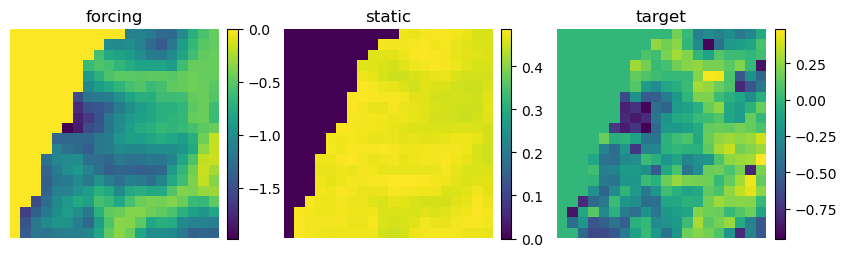

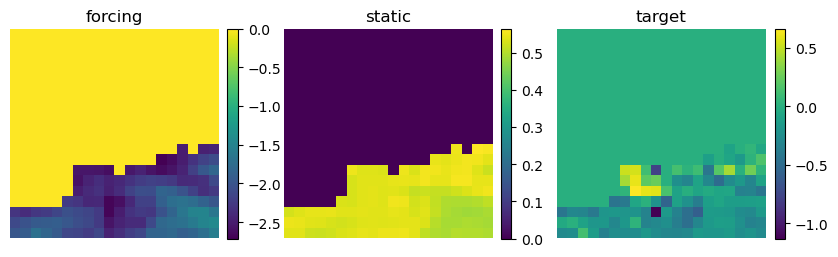

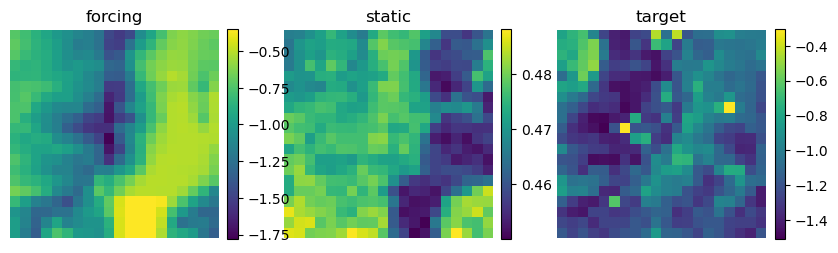

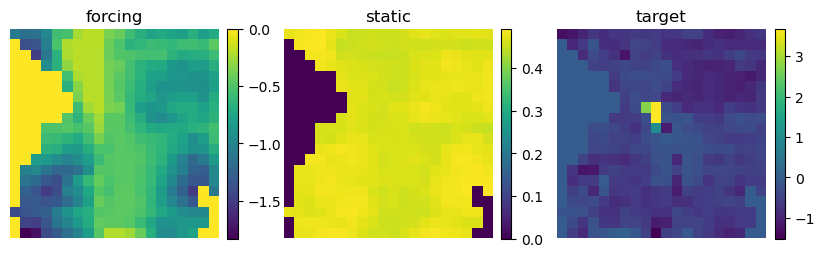

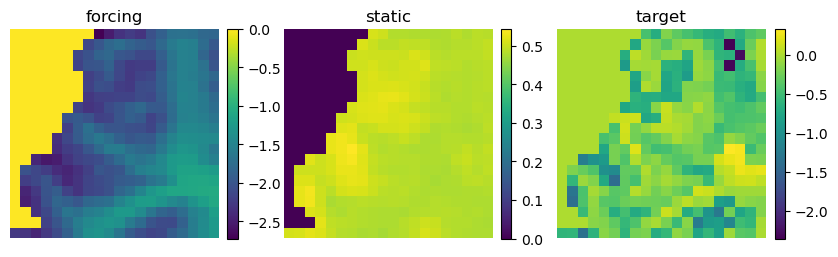

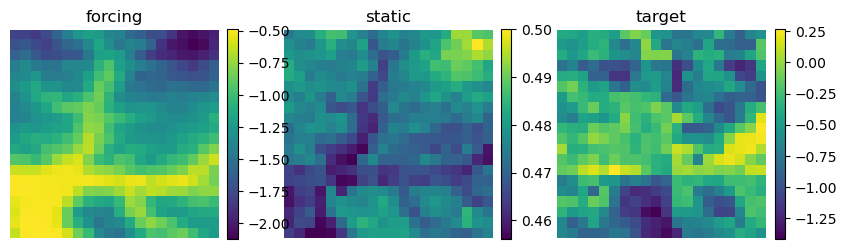

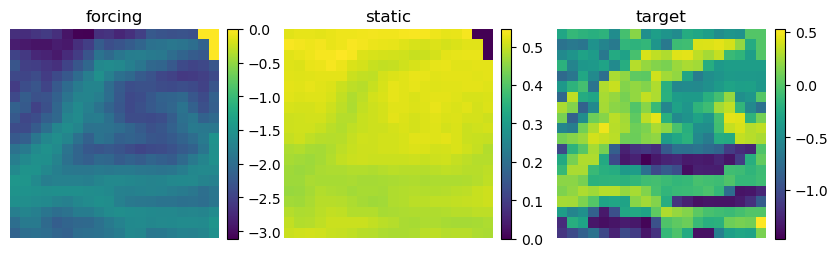

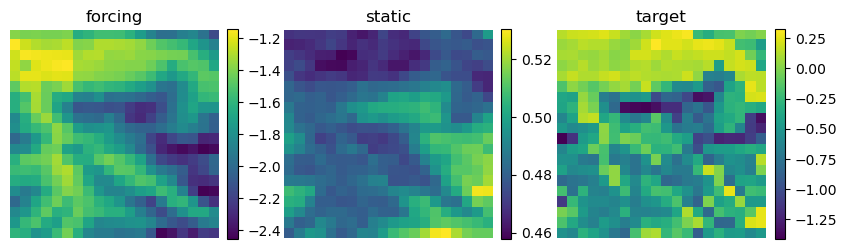

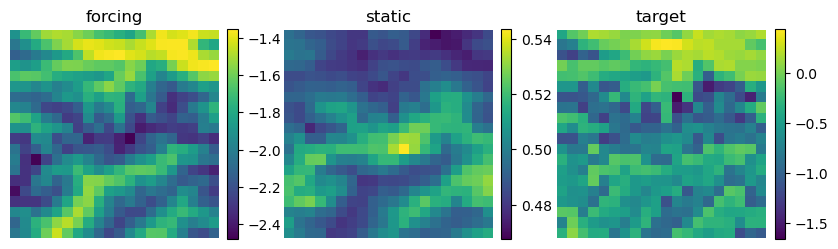

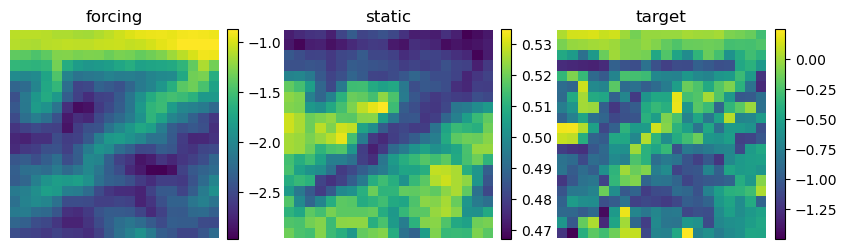

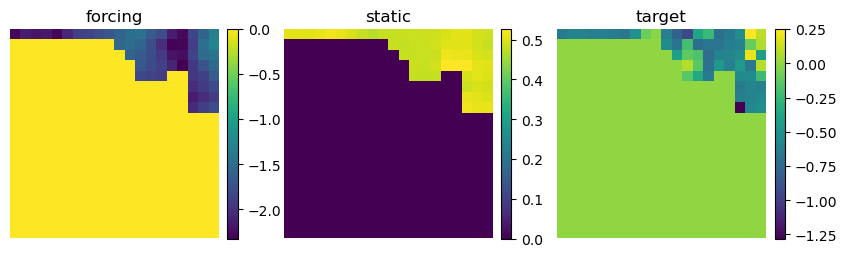

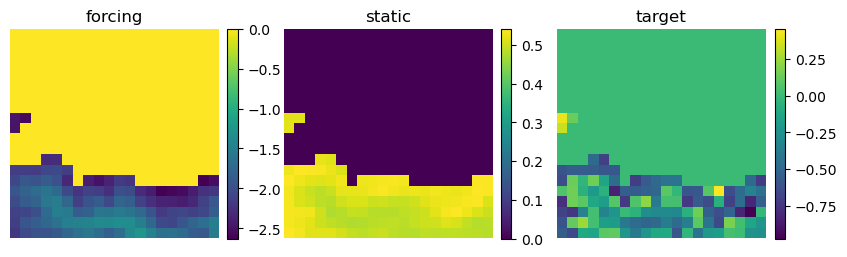

In [135]:
i = 0
for tx,ts,ty in test_dataloader:
    #print(tx.shape,ts.shape, ty.shape)
    for b in range(tx.shape[0]):
        fig, axs = plt.subplots(1,3, figsize=(10,5))
        p1 = axs[0].imshow(tx[b , 20, 2 , ...]) # N L C H W
        axs[0].set_title("forcing")
        plt.colorbar(p1,fraction=0.046, pad=0.04)
        axs[0].axis("off")
        
        p2 = axs[1].imshow(ts[b , 20, 0 , ...])
        axs[1].set_title("static")
        axs[1].axis("off")
        plt.colorbar(p2,fraction=0.046, pad=0.04)
        
        p3 = axs[2].imshow(ty[b , 20, 0, ...])
        axs[2].set_title("target")
        plt.colorbar(p3,fraction=0.046, pad=0.04)
        axs[2].axis("off")
    i += 1
    if i > 3:
        break

In [ ]:
from hython.models.convLSTM import ConvLSTM

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
HIDDEN_SIZE

In [ ]:
model = ConvLSTM(
    input_dim =  DYNAMIC_INPUT_SIZE + STATIC_INPUT_SIZE,
    output_dim= OUTPUT_SIZE,
    hidden_dim = (HIDDEN_SIZE),
    kernel_size = KERNEL_SIZE,
    num_layers = NUM_LSTM_LAYER,
    batch_first = True,
    bias = True,
    return_all_layers = False
).to(device)

In [ ]:
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=10)

loss_fn = RMSELoss(target_weight=TARGET_WEIGHTS)
metric_fn = MSEMetric(target_names=target_names)

In [142]:
trainer = HythonTrainer(
    RNNTrainParams(
               experiment=experiment, 
               temporal_subsampling=False, 
               temporal_subset=1, 
               seq_length=SEQ_LENGTH, 
               target_names=target_names,
               metric_func=metric_fn,
               loss_func=loss_fn)
)

In [143]:
file_surr_output = f"{dir_surr_output}/{experiment}_{surr_model_output}"

In [ ]:
# train
model, loss_history, metric_history = train_val(
    trainer,
    model,
    train_dataloader,
    test_dataloader,
    EPOCHS,
    opt,
    lr_scheduler,
    file_surr_output,
    device,
)

In [145]:
model

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(33, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (fc1): Linear(in_features=24, out_features=2, bias=True)
)

In [146]:
model.load_state_dict(torch.load("/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/exp1_convlstm.pt"))

<All keys matched successfully>

NameError: name 'loss_history' is not defined

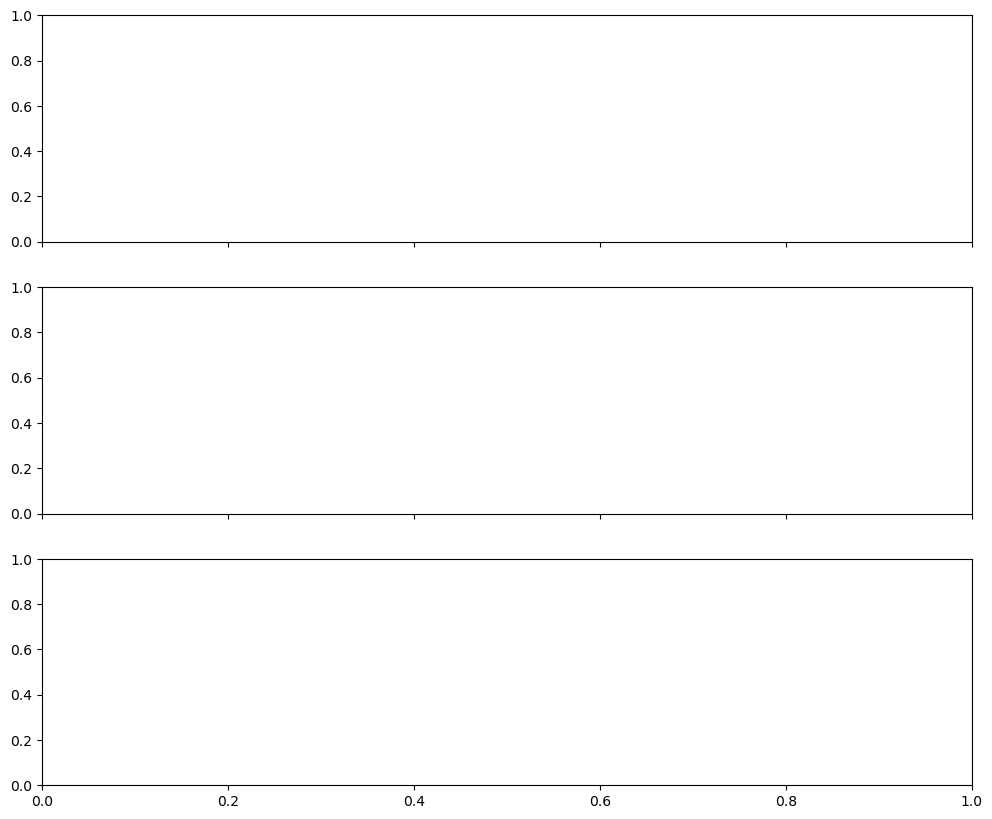

In [147]:
lepochs = list(range(1, EPOCHS + 1))

fig, axs = plt.subplots(len(target_names) +1, 1, figsize= (12,10), sharex=True)

axs[0].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[0].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
axs[0].set_title('Loss')
#axs[0].set_xlabel('Epochs')
axs[0].set_ylabel(loss_fn.__name__)
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1,1))

for i, variable in enumerate(target_names):
    #plt.show()
    axs[i+1].plot(lepochs, metric_history[f'train_{variable}'], marker='.', linestyle='-', color='b', label='Training')
    axs[i+1].plot(lepochs, metric_history[f'val_{variable}'], marker='.', linestyle='-', color='r', label='Validation')
    axs[i+1].set_title(variable)
    axs[i+1].set_ylabel(metric_fn.__class__.__name__)
    axs[i+1].grid(True)
    axs[i+1].legend(bbox_to_anchor=(1,1))

In [148]:
def predict(Xd, Xs, model, batch_size, device):
    model = model.to(device)
    if len(Xs[0]) > 1:
        X = torch.concat([Xd, Xs], 2).to(device)
    else:
        X = Xd.to(device)
    arr = []
    for i in range(0, Xd.shape[0], batch_size):
        out = model(X)[0]
        #import pdb;pdb.set_trace()
        arr.append(out[i : (i + batch_size)].detach().cpu().numpy())
    return np.vstack(arr)

In [149]:
res = next(iter(test_dataloader))

In [150]:
# res[0] = res[0].where(res[0] > -999, np.nan)
# res[1] = res[1].where(res[1] > -999, np.nan)
# res[2] = res[2].where(res[2] > -999, np.nan)


In [151]:
output = predict(res[0], res[1], model, batch_size=8,device=device)

In [152]:
import matplotlib.pyplot as plt

In [153]:
output.shape

(3, 60, 20, 20, 2)

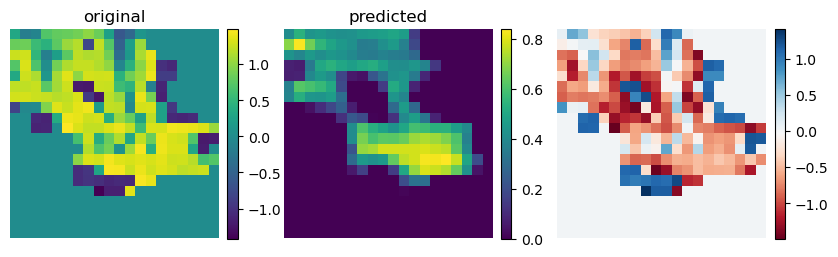

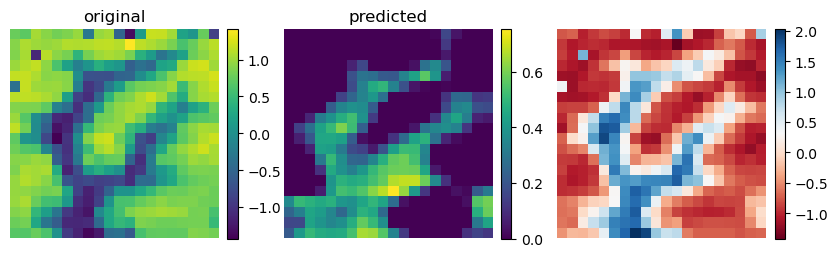

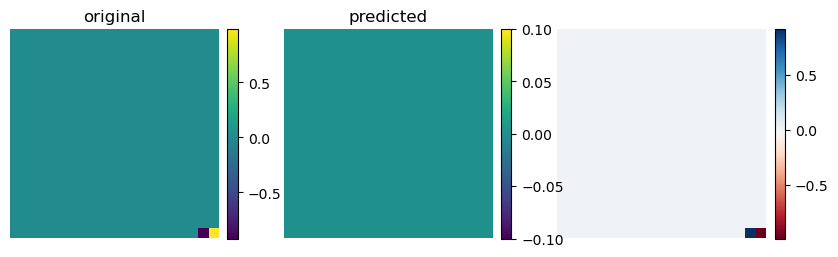

In [154]:
VARIABLE = 0
# target
for i in range(output.shape[0]):
    fig, axs = plt.subplots(1,3, figsize = (10,4))
    p1 = axs[0].imshow(res[2][i,-1,VARIABLE,:,:])
    axs[0].axis("off")
    plt.colorbar(p1,fraction=0.046, pad=0.04)
    axs[0].set_title("original")
    p2 = axs[1].imshow(output[i,-1,:,:,VARIABLE])
    plt.colorbar(p2,fraction=0.046, pad=0.04)
    axs[1].set_title("predicted")
    axs[1].axis("off")
    p3 = axs[2].imshow((output[i,-1,:,:,VARIABLE] - np.array(res[2][i,-1,VARIABLE,:,:])), cmap="RdBu")
    plt.colorbar(p3,fraction=0.046, pad=0.04)
    axs[2].axis("off")

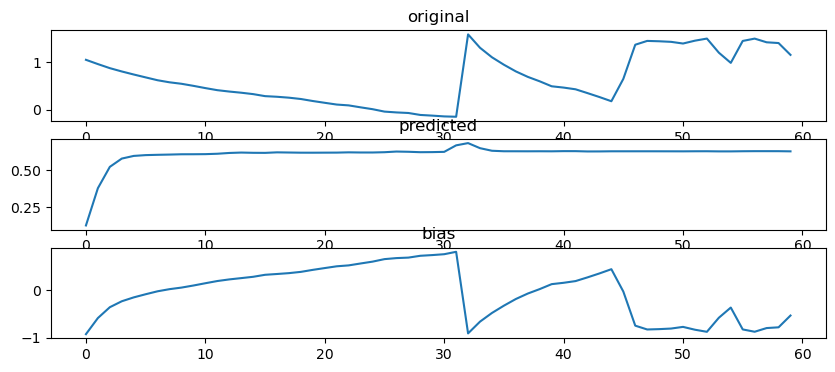

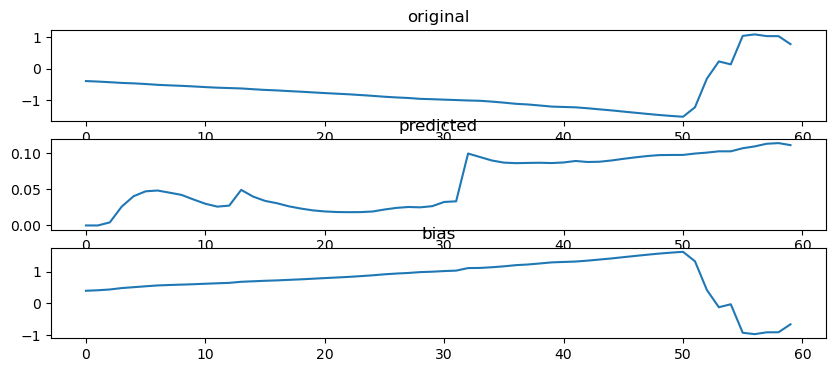

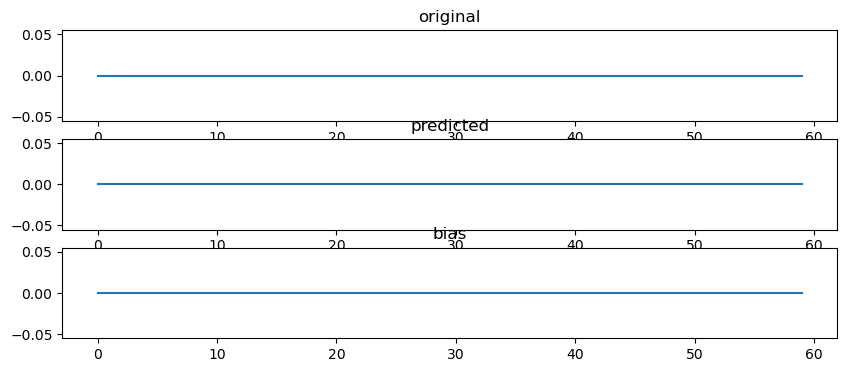

In [155]:
VARIABLE = 0
# target
for i in range(output.shape[0]):
    fig, axs = plt.subplots(3,1, figsize = (10,4))
    p1 = axs[0].plot(res[2][i,:,VARIABLE,10,10])
    #axs[0].axis("off")
    #plt.colorbar(p1,fraction=0.046, pad=0.04)
    axs[0].set_title("original")
    p2 = axs[1].plot(output[i,: ,10, 10,VARIABLE])
    #plt.colorbar(p2,fraction=0.046, pad=0.04)
    axs[1].set_title("predicted")
    #axs[1].axis("off")
    p3 = axs[2].plot((output[i,:,10,10,VARIABLE] - np.array(res[2][i,:,VARIABLE,10,10]))) #, cmap="RdBu")
    #plt.colorbar(p3,fraction=0.046, pad=0.04)
    #axs[2].axis("off")
    axs[2].set_title("bias")


In [97]:
torch

<module 'torch' from '/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/torch/__init__.py'>

In [ ]:
torch.split?

## Refactor dataset

In [167]:
mask_names = ["mask_missing", "mask_lake"]
SURROGATE_INPUT = (
    "https://eurac-eo.s3.amazonaws.com/INTERTWIN/"
    "SURROGATE_INPUT/adg1km_eobs_preprocessed.zarr/"
)
Xd = (
    read_from_zarr(url=SURROGATE_INPUT, group="xd", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .xd.sel(feat=dynamic_names)
)
Xs = read_from_zarr(
    url=SURROGATE_INPUT, group="xs", multi_index="gridcell").xs.sel(
    feat=static_names
)
Y = (
    read_from_zarr(url=SURROGATE_INPUT, group="y", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .y.sel(feat=target_names)
)

SHAPE = Xd.attrs["shape"]

# === READ TEST ==========================================================

Y_test = (
    read_from_zarr(url=SURROGATE_INPUT, group="y", multi_index="gridcell")
    .sel(time=test_temporal_range)
    .y.sel(feat=target_names)
)
Xd_test = (
    read_from_zarr(url=SURROGATE_INPUT, group="xd", multi_index="gridcell")
    .sel(time=test_temporal_range)
    .xd.sel(feat=dynamic_names)
)

masks = (
    read_from_zarr(url=SURROGATE_INPUT, group="mask")
    .mask.sel(mask_layer=mask_names)
    .any(dim="mask_layer")
)

In [168]:
from hython.sampler import AbstractDataSampler, SamplerResult, RegularIntervalDownsampler
from hython.normalizer import Normalizer

In [169]:
class RegularIntervalDownsampler(AbstractDataSampler):
    def __init__(self, intervals: list[int], origin: list[int]):
        self.intervals = intervals
        self.origin = origin

        if intervals[0] != intervals[1]:
            raise NotImplementedError("Different x,y intervals not yet implemented!")

        if origin[0] != origin[1]:
            raise NotImplementedError("Different x,y origins not yet implemented!")

    def sampling_idx(
        self, indexes, shape
    ):  # remove missing is a 2D mask
        """Sample a N-dimensional array by regularly-spaced points along the spatial axes.

        mask_missing, removes missing values from grid where mask is True
        """

        xr_coords = None
        sampled_grid = None
        sampled_grid_dims = None

        idx_nan = np.array([])

        ishape, iorigin, iintervals = (
            shape[0],
            self.origin[0],
            self.intervals[0],
        )  # rows (y, lat)
        
        jshape, jorigin, jintervals = (
            shape[1],
            self.origin[1],
            self.intervals[1],
        )  # columns (x, lon)

        #import pdb;pdb.set_trace()
        irange = np.arange(iorigin, ishape, iintervals)
        jrange = np.arange(jorigin, jshape, jintervals)

        idxs_sampled = indexes[irange[:, None], jrange].flatten()  # broadcasting

        # if missing_mask is not None:
        #     idx_nan = grid_idx[missing_mask]

        #     idx_sampled_1d_nomissing = np.setdiff1d(idx_sampled, idx_nan)
        # else:
        #     idx_sampled_1d_nomissing = idx_sampled


        return idxs_sampled

In [223]:
from hython.datasets.datasets import LSTMDataset

In [199]:
class LSTMDatasetNew(Dataset):
    def __init__(
        self,
        xd,
        y,
        xs = None,
        original_domain_shape = (),
        mask = None,
        downsampler = None, 
        normalizer_dynamic = None,
        normalizer_static = None,
        normalizer_target = None
    ):

        self.shape = original_domain_shape

        self.xd = xd.copy()
        self.y = y.copy()
        self.xs = xs.copy()

        self.downsampler = downsampler


        # compute indexes

        ishape = self.shape[0]  # rows (y, lat)
        jshape = self.shape[1]  # columns (x, lon)

        irange = np.arange(0, ishape, 1)
        jrange = np.arange(0, jshape, 1)

        self.grid_idx_2d = compute_grid_indices(shape=self.shape)
        self.grid_idx_1d = self.grid_idx_2d.flatten()
        print(self.grid_idx_1d)

        # IF DOWNSAMPLING 
        # Reduces the available indexes to a valid subset
        if downsampler:
            # Same keep only indexes that satisfy some rule
            self.grid_idx_1d_downsampled = self.downsampler.sampling_idx(self.grid_idx_2d, self.shape)

        # IF REMOVE MISSING FROM MASK
        # Reduces the available indexes to a valid subset
        if mask is not None:
            # This actually does not touch the dataset, only remove indexes corresponding to missing values from the available indexes
            idx_nan = self.grid_idx_2d[mask]
            
            if downsampler:
                self.grid_idx_1d_valid = np.setdiff1d(self.grid_idx_1d_downsampled, idx_nan)
            else:
                self.grid_idx_1d_valid = np.setdiff1d(self.grid_idx_1d, idx_nan)
        else:
            if downsampler:
                self.grid_idx_1d_valid = self.grid_idx_1d_downsampled
            else:
                self.grid_idx_1d_valid = self.grid_idx_1d

        # NORMALIZE BASED IF MAKS AND IF DOWNSAMPLING
        if normalizer_dynamic is not None or normalizer_target is not None or normalizer_static is not None:
            # this normalize the data corresponding to valid indexes
            
            if normalizer_dynamic.stats_iscomputed: # validation or test
                self.xd = normalizer_dynamic.normalize(self.xd)
            else:
                # compute stats for training
                normalizer_dynamic.compute_stats(self.xd[self.grid_idx_1d_valid])
                self.xd = normalizer_dynamic.normalize(self.xd)
                
            if normalizer_static.stats_iscomputed: # validation or test
                self.xs = normalizer_static.normalize(self.xs)
            else:
                if downsampler:
                    normalizer_static.compute_stats(self.xs[self.grid_idx_1d_valid])
                else:
                    normalizer_static.compute_stats(self.xs)
                    
                self.xs = normalizer_static.normalize(self.xs)
                
            if normalizer_target.stats_iscomputed: # validation or test
                self.y = normalizer_target.normalize(self.y)
            else:
                normalizer_target.compute_stats(self.y[self.grid_idx_1d_valid])
                self.y = normalizer_target.normalize(self.y)
                
        

        self.xs = self.xs.astype(np.float32)

        if isinstance(self.xd, xr.DataArray):
            self.xd = torch.tensor(self.xd.values)
            self.y = torch.tensor(self.y.values)
            self.xs = torch.tensor(self.xs.values)
        else:
            self.xd = torch.tensor(self.xd)
            self.y = torch.tensor(self.y)
            self.xs = torch.tensor(self.xs)


    def __len__(self):
        return len(self.grid_idx_1d_valid)

    def __getitem__(self, index):
        if self.xs is not None:
            return self.xd[index], self.xs[index], self.y[index]
        else:
            return self.xd[index], self.y[index]

In [200]:
masks

<xarray.DataArray 'mask' (lat: 180, lon: 223)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * lat          (lat) float64 47.08 47.07 47.06 47.05 ... 45.46 45.45 45.44
    layer        int64 ...
  * lon          (lon) float64 10.29 10.3 10.31 10.32 ... 12.3 12.31 12.32 12.33
    spatial_ref  int64 ...

In [201]:
downsampler_train = RegularIntervalDownsampler(
    intervals=[4,4], origin=[0,0]
)

downsampler_test = RegularIntervalDownsampler(
    intervals=[4,4], origin=[2,2]
)

normalizer_dynamic = Normalizer(method="standardize", type="spacetime", axis_order = "NTC")
normalizer_static = Normalizer(method="standardize", type="space", axis_order = "NTC")
normalizer_target = Normalizer(method="standardize", type="spacetime", axis_order = "NTC")


shape = dynamic.isel(time=1).precip.shape

In [202]:
train_dataset = LSTMDatasetNew(
    Xd,
    Y,
    Xs,
    original_domain_shape=SHAPE,
    mask = masks,
    downsampler = downsampler_train,
    normalizer_dynamic = normalizer_dynamic,
    normalizer_static = normalizer_static,
    normalizer_target = normalizer_target
)
   

[    0     1     2 ... 40137 40138 40139]
compute stats
compute stats
compute stats


In [203]:
test_dataset = LSTMDatasetNew(
    Xd_test,
    Y_test,
    Xs,
    original_domain_shape=shape,
    mask = masks,
    downsampler = downsampler_test,
    normalizer_dynamic = normalizer_dynamic,
    normalizer_static = normalizer_static,
    normalizer_target = normalizer_target
)

[    0     1     2 ... 40137 40138 40139]


In [205]:
#check normalization

In [210]:
np.nanmean(train_dataset.xd, (0,1)), np.nanstd(train_dataset.xd, (0,1))

(array([-0.00044793,  0.00076256,  0.00115237], dtype=float32),
 array([0.9497539 , 0.98993504, 0.9864905 ], dtype=float32))

In [ ]:
np.nanmean(train_dataset.y, (0,1)), np.nanstd(train_dataset.y, (0,1))

In [ ]:
plt.hist(train_dataset.y[:,0,-1].flatten())

In [212]:
np.nanmean(train_dataset.xs, (0)), np.nanstd(train_dataset.xs, (0))

(array([0.00077574, 0.01527992, 0.00765937, 0.01625074, 0.00473096,
        0.01034903], dtype=float32),
 array([1.0155501 , 1.0093167 , 0.99684393, 0.9982191 , 0.99113834,
        1.0049132 ], dtype=float32))

In [ ]:
from hython.sampler import SamplerBuilder2

In [176]:
train_sampler_builder = SamplerBuilder2(sampling_method= "default", 
                                        minibatch_sampling="random", 
                                        processing="single-gpu")

test_sampler_builder = SamplerBuilder2(sampling_method= "default", 
                                        minibatch_sampling="sequential", 
                                        processing="single-gpu")

In [177]:
train_sampler_builder.initialize(
    train_dataset.grid_idx_1d_valid
)
test_sampler_builder.initialize(
    test_dataset.grid_idx_1d_valid
)

train_sampler = train_sampler_builder.get_sampler()
test_sampler = test_sampler_builder.get_sampler()

In [178]:
train_loader = DataLoader(train_dataset, batch_size=BATCH , sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH , sampler=test_sampler)

In [139]:
train_loader

In [140]:
dataset_train[1][0].shape

torch.Size([1096, 3])

In [141]:
dataset_train.xd.shape

torch.Size([40140, 1096, 3])

In [142]:
for t,b,a in train_loader:
    if float(torch.any(torch.isnan(t))):
        print("nan")
        break

In [111]:
len(dataset_train.grid_idx_1d), len(dataset_train.grid_idx_1d_downsampled), len(dataset_train.grid_idx_1d_valid)

(40140, 2520, 963)

In [112]:
downsampler

In [113]:
from hython.viz import plot_sampler

In [114]:
vars(dataset_train).keys()

dict_keys(['shape', 'xd', 'y', 'xs', 'downsampler', 'grid_idx_2d', 'grid_idx_1d', 'grid_idx_1d_downsampled', 'grid_idx_1d_valid'])

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm, CenteredNorm
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs


def plot_sampler(
    da_bkg, ds_train, ds_test, figsize=(10, 10), markersize=10, cmap="terrain"
):
    vv = da_bkg

    vv = vv.assign_coords({"gridcell": (("lat", "lon"), ds_train.grid_idx_2d)})

    vv = vv.assign_coords({"gridcell_valid": (("lat", "lon"), ds_test.grid_idx_2d)})

    tmp = np.zeros(vv.shape).astype(np.bool_)
    for i in ds_train.grid_idx_1d_valid:
        tmp[vv.gridcell == i] = True

    tmp_valid = np.zeros(vv.shape).astype(np.bool_)
    for i in ds_test.grid_idx_1d_valid:
        tmp_valid[vv.gridcell_valid == i] = True

    df = vv.where(tmp).to_dataframe().dropna().reset_index()

    df_valid = vv.where(tmp_valid).to_dataframe().dropna().reset_index()

    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(x=df.lon, y=df.lat), crs=4326
    )

    gdf_valid = gpd.GeoDataFrame(
        df_valid, geometry=gpd.points_from_xy(x=df_valid.lon, y=df_valid.lat), crs=4326
    )

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    # p = da_bkg.plot(ax = ax, add_colorbar=True, alpha = 0.3, cmap=cmap, cbar_kwargs={"shrink":0.3})
    # p.colorbar.ax.set_ylabel('Elevation (m a.s.l.)', labelpad=10)
    # #p.colorbar.ax.set_label('standard deviation', rotation=270, labelpad=15)
    # gdf.plot(ax=ax, color="red", markersize= markersize, label="training")
    # gdf_valid.plot(ax=ax, color="black", markersize= markersize, label = "validation")
    # plt.legend(bbox_to_anchor=(1, 0.9), frameon = False)
    # plt.title("")
    # plt.gca().set_axis_off()
    # #ax.set_xlim([6, 7.5])
    # #ax.set_ylim([45.5, 46.5])

    from matplotlib.colors import ListedColormap

    cmap = plt.colormaps["terrain"]
    # cmap = ListedColormap(["black", "gold", "lightseagreen", "purple", "blue"])
    vmin = 0
    vmax = 5
    ticks = [
        -0.5,
        0.5,
        1.5,
        2.5,
        3.5,
        4.5,
    ]  # np.linspace(start=vmin + 0.5, stop=vmax, num=vmax+1)

    labels = {
        0: "0-500",
        1: "500-1000",
        2: "1000-1500",
        3: "1500-2000",
        4: "2000-2500",
        5: ">2500",
    }

    norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], ncolors=cmap.N, clip=True)

    norm.vmin = vmin
    norm.vmax = vmax
    p = da_bkg.plot.imshow(
        cmap=cmap,
        norm=norm,
        # vmin=vmin, vmax=vmax,
        add_colorbar=True,
        cbar_kwargs={"shrink": 0.3},
        ax=ax,
    )

    ilabels = [labels.get(i, "No Data") for i in range(vmax + 1)]
    p.colorbar.set_ticks(ticks, labels=ilabels)
    
    p.colorbar.ax.set_ylabel("Elevation bands (m a.s.l.)", rotation=270, labelpad=10)
    #plt.axis("off")
    plt.title("")

    gdf.plot(ax=ax, color="red", markersize= markersize, label="training")
    gdf_valid.plot(ax=ax, color="black", markersize= markersize, label="test/validation")
             
    return fig, ax, gdf, gdf_valid

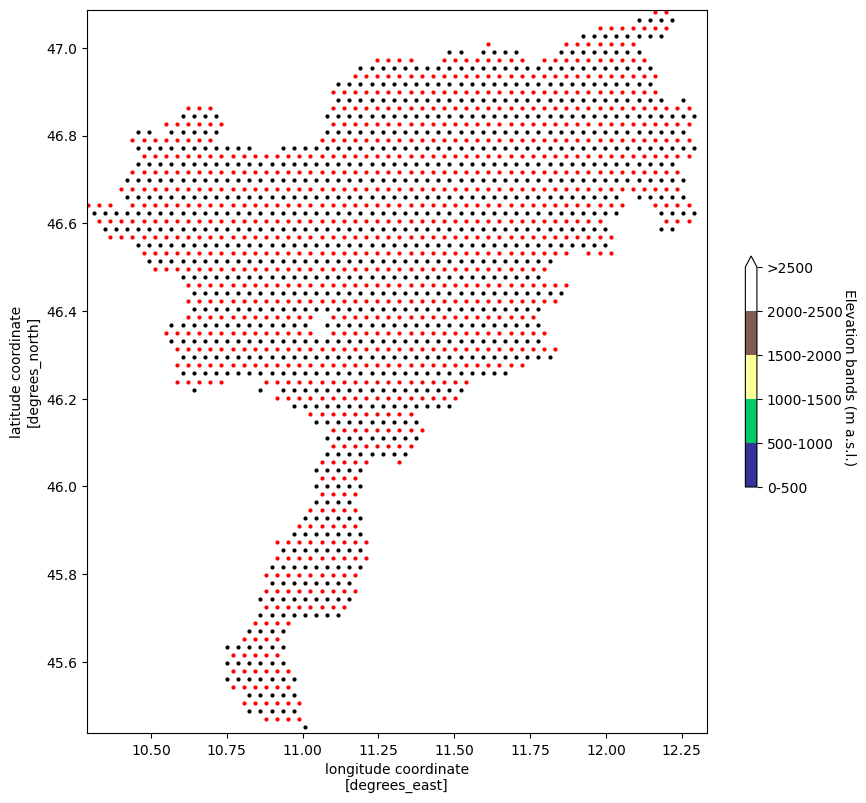

In [137]:
_,_, tmp, tmp_valid = plot_sampler(wflow_dem, dataset_train, dataset_test, markersize=4)

# REFACTOR CUBELETS DATASET

In [ ]:
from hython.datasets.datasets import CubeletsDataset

In [15]:
from hython.normalizer import Normalizer

normalizer_dynamic = Normalizer(method = "standardize", type="spacetime", axis_order = "xarray_dataset", dask_compute=False)
normalizer_static = Normalizer(method = "standardize", type="space", axis_order = "xarray_dataset", dask_compute=False)
normalizer_target = Normalizer(method = "standardize", type="spacetime", axis_order = "xarray_dataset", dask_compute=False)

TMP_STATS = "."

dynamic_train = normalizer_dynamic.normalize(dynamic_train, write_to = f"{TMP_STATS}/xd.nc")
static = normalizer_static.normalize(static, write_to = f"{TMP_STATS}/xs.nc")
target_train = normalizer_target.normalize(target_train, write_to = f"{TMP_STATS}/y.nc")

dynamic_test = normalizer_dynamic.normalize(dynamic_test)
target_test = normalizer_target.normalize(target_test)

compute stats
write stats to ./xd.nc
compute stats
write stats to ./xs.nc
compute stats
write stats to ./y.nc


In [16]:
# PARAMETERS
XSIZE,YSIZE, TSIZE = 20, 20, 60
XOVER,YOVER,TOVER = 10, 10, 30